In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.6 MB/s eta 0:00:00


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import random
import zipfile

In [ ]:
from segmentation_models.metrics import iou_score, f1_score
from segmentation_models.losses import dice_loss

Segmentation Models: using `keras` framework.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/200040076_EE610_Assignment4/200040076_EE610_Assignment4.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Source for above code : https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

In [ ]:
trn_image_name = os.listdir('/tmp/EE610_Assignment4/Train/Tissue-Images')
trn_mask_name = os.listdir('/tmp/EE610_Assignment4/Train/Binary-Mask')

In [ ]:
tst_image_name = os.listdir('/tmp/EE610_Assignment4/Test/Tissue-Images')
tst_mask_name = os.listdir('/tmp/EE610_Assignment4/Test/Binary-Mask')

In [ ]:
trn_image_name.sort()
trn_mask_name.sort()

In [ ]:
tst_image_name.sort()
tst_mask_name.sort()

In [ ]:
# Preprocessing
trn_image = []
trn_mask = []
tst_image = []
tst_mask = []

In [ ]:
for i in range(len(tst_image_name)):
  mask = cv2.imread(f'/content/drive/MyDrive/200040076_EE610_Assignment4/Test/Binary-Mask/{tst_mask_name[i]}')
  mask = cv2.resize(mask, (64, 64))
  mask = mask/255
  tst_mask.append(mask)

  image = cv2.imread(f'/content/drive/MyDrive/200040076_EE610_Assignment4/Test/Tissue-Images/{tst_image_name[i]}')
  image = cv2.resize(image, (64, 64))
  image = image/255
  tst_image.append(image)

In [ ]:
for i in range(len(trn_image_name)):
  mask = cv2.imread(f'/content/drive/MyDrive/200040076_EE610_Assignment4/Train/Binary-Mask/{trn_mask_name[i]}')
  mask = cv2.resize(mask, (64, 64))
  mask = mask/255
  trn_mask.append(mask)

  image = cv2.imread(f'/content/drive/MyDrive/200040076_EE610_Assignment4/Train/Tissue-Images/{trn_image_name[i]}')
  image = cv2.resize(image, (64, 64))
  image = image/255
  trn_image.append(image)

In [ ]:
trn_image, val_image, trn_mask, val_mask = train_test_split(trn_image, trn_mask, test_size=0.25)

In [ ]:
trn_image = tf.convert_to_tensor(trn_image)
val_image = tf.convert_to_tensor(val_image)
tst_image = tf.convert_to_tensor(tst_image)

In [ ]:
trn_mask = tf.convert_to_tensor(trn_mask)
val_mask = tf.convert_to_tensor(val_mask)
tst_mask = tf.convert_to_tensor(tst_mask)

In [ ]:
trn_mask = tf.image.rgb_to_grayscale(trn_mask)

In [ ]:
tst_mask = tf.image.rgb_to_grayscale(tst_mask)
val_mask = tf.image.rgb_to_grayscale(val_mask)

Train_Image_No. 15


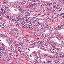

Train_Mask_No. 15


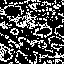

In [ ]:
print(f"Train_Image_No. 15")
cv2_imshow(trn_image[15].numpy()*255)
print(f"Train_Mask_No. 15")
cv2_imshow(trn_mask[15].numpy()*255)

## UNet Model

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu' )(x)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  c = BatchNormalization()(c)
  p = MaxPool2D((2, 2), (2, 2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding='same', strides=1):
  us = UpSampling2D((2, 2))(x)
  concat = Concatenate()([us, skip])
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  c = BatchNormalization()(c)
  return c

def bottleneck(x, filters, kernel_size=(3, 3), padding='same', strides=1):
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
  c = BatchNormalization()(c)
  c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
  c = BatchNormalization()(c)
  return c

In [ ]:
def UNet(image_size=(64, 64, 3)):
  f = [16, 32, 64, 128, 256]
  inputs = Input(image_size)

  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])

  bn = bottleneck(p4, f[4])

  u1 = up_block(bn, c4, f[3])
  u2 = up_block(u1, c3, f[2])
  u3 = up_block(u2, c2, f[1])
  u4 = up_block(u3, c1, f[0])

  outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u4)
  model = Model(inputs, outputs)
  return model

In [ ]:
model = UNet(image_size=(64, 64, 3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   2320        ['batch_normalization[0][0]']

In [ ]:
model.compile(optimizer = Adagrad(learning_rate = 0.1), loss = dice_loss, metrics = [f1_score])

In [ ]:
model_history = model.fit(x=trn_image, y=trn_mask, batch_size=11, epochs=10, validation_data=(val_image, val_mask), verbose=1)

Epoch 1/10
3/3 [==============================] - 5s 930ms/step - loss: 0.6182 - f1-score: 0.3818 - val_loss: 0.6936 - val_f1-score: 0.3064
Epoch 2/10
3/3 [==============================] - 2s 712ms/step - loss: 0.5481 - f1-score: 0.4519 - val_loss: 0.6900 - val_f1-score: 0.3100
Epoch 3/10
3/3 [==============================] - 2s 731ms/step - loss: 0.5105 - f1-score: 0.4895 - val_loss: 0.6863 - val_f1-score: 0.3137
Epoch 4/10
3/3 [==============================] - 2s 706ms/step - loss: 0.4833 - f1-score: 0.5167 - val_loss: 0.6903 - val_f1-score: 0.3097
Epoch 5/10
3/3 [==============================] - 2s 732ms/step - loss: 0.4668 - f1-score: 0.5332 - val_loss: 0.6907 - val_f1-score: 0.3093
Epoch 6/10
3/3 [==============================] - 2s 715ms/step - loss: 0.4505 - f1-score: 0.5495 - val_loss: 0.6944 - val_f1-score: 0.3056
Epoch 7/10
3/3 [==============================] - 2s 721ms/step - loss: 0.4359 - f1-score: 0.5641 - val_loss: 0.7061 - val_f1-score: 0.2939
Epoch 8/10
3/3 [====

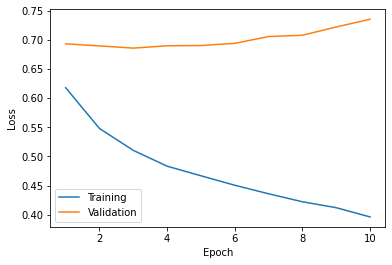

In [ ]:
x = np.arange(1, 11)
plt.plot(x, model_history.history['loss'])
plt.plot(x, model_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

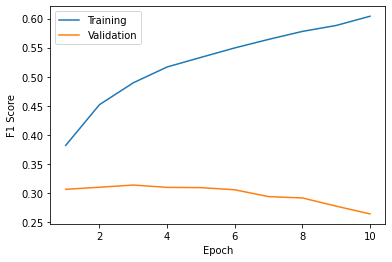

In [ ]:
plt.plot(x, model_history.history['f1-score'])
plt.plot(x, model_history.history['val_f1-score'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
pred_tst = model.predict(tst_image)
pred_thres =pred_tst.copy()

1/1 [==============================] - 0s 166ms/step


In [ ]:
pred_thres[pred_tst>0.25]=1
pred_thres[pred_tst<0.25]=0

In [ ]:
tst_mask=np.float32(tst_mask)

In [ ]:
print(f'F1_Score_on_test_data : {f1_score(tst_mask, pred_thres)}')

F1_Score_on_test_data : 0.6353851556777954


6
Test Image


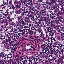

Actual Mask


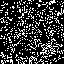

Predicted Mask


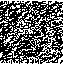

In [ ]:
n = random.randrange(0, 13)
print(n)
print("Test Image")
cv2_imshow(tst_image[n].numpy()*255)
print("Actual Mask")
cv2_imshow(tst_mask[n]*255)
print("Predicted Mask")
cv2_imshow(pred_thres[n]*255)